# Usage (quick version)

## Preparation

In [1]:
# Standard users
# !pip install covsirphy
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [2]:
import covsirphy as cs
cs.__version__

'2.5.1'

## Dataset preparation
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.

In [3]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt(verbose=True)

### The number of cases (JHU style)

In [4]:
# Description/citation
print(jhu_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [5]:
print(data_loader.covid19dh_citation)

Australian Bureau of Statistics (2019), https://www.abs.gov.au/
CIA - Central Intelligence Agency (2018), https://www.cia.gov/
CIA - Central Intelligence Agency (2019), https://www.cia.gov/
CIA - Central Intelligence Agency (2020), https://www.cia.gov/
COVID-19 Turkey API (2020), https://github.com/
COVID-19_plus_Russia GitHub repository (2020), https://github.com/
COVID19-India API (2020), https://www.covid19india.org/
Canada's National Statistical Agency (2020), https://www150.statcan.gc.ca/
Centre of Excellence in Economics and Data Science, University of Milano (2020), https://github.com/
Covid19data.com.au (2020), https://github.com/
Czech Statistical Office (2018), https://www.czso.cz/
Data Science for Social Impact research group, University of Pretoria (2020), https://github.com/
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be/
Eurostat (2019), https://ec.europa.eu/
Geloky (2019), https://geloky.com/
Istituto Nazionale di Statistica, Italia (2018), htt

In [6]:
# Raw data
jhu_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
144195,2020-07-10,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
144196,2020-07-11,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
144197,2020-07-12,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
144198,2020-07-13,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
144199,2020-07-14,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04


In [7]:
# Cleaned data
jhu_data.cleaned().tail()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered
144195,2020-07-10,Colombia,Vichada,1,0,0,1
144196,2020-07-11,Colombia,Vichada,1,0,0,1
144197,2020-07-12,Colombia,Vichada,1,0,0,1
144198,2020-07-13,Colombia,Vichada,1,0,0,1
144199,2020-07-14,Colombia,Vichada,1,0,0,1


In [8]:
# Subset for a country
jhu_data.subset("Japan", province="Tokyo").tail()

,Date,Confirmed,Infected,Fatal,Recovered
177,2020-07-10,7515,1211,325,5979
178,2020-07-11,7721,1302,325,6094
179,2020-07-12,7927,1433,325,6169
180,2020-07-13,8046,1498,325,6223
181,2020-07-14,8189,1528,325,6336


In [9]:
# Total
total_df = jhu_data.total()
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2020-07-10,18736135,9091167,821094,8823874,0.043824,0.470955,0.085132
2020-07-11,19100071,9287398,827355,8985318,0.043317,0.470434,0.084315
2020-07-12,19407504,9448322,832271,9126911,0.042884,0.470277,0.083568
2020-07-13,19674379,9524549,836991,9312839,0.042542,0.473349,0.082464
2020-07-14,19675102,9524845,836992,9313265,0.042541,0.473353,0.082460


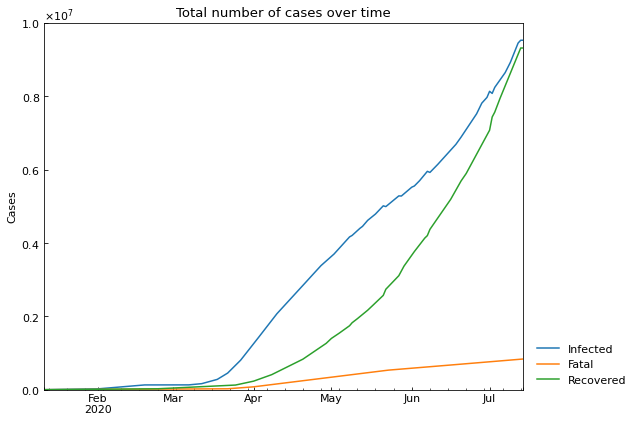

In [10]:
# Plot the total values
cs.line_plot(total_df[["Infected", "Fatal", "Recovered"]], "Total number of cases over time")

### (Optional) Replace the dataset in Japan


In [11]:
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
181,2020-07-10,21145,2517,981,17647
182,2020-07-11,21529,2707,982,17840
183,2020-07-12,21937,2955,982,18000
184,2020-07-13,22198,3115,983,18100
185,2020-07-14,22518,3259,983,18276


In [12]:
japan_data = data_loader.japan()
print(japan_data.citation)

Lisphilar (2020), COVID-19 dataset in Japan, GitHub repository, https://github.com/lisphilar/covid19-sir/data/japan

In [13]:
jhu_data.replace(japan_data)
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
149,2020-07-09,20371,1924,981,17466
150,2020-07-10,20719,2085,982,17652
151,2020-07-11,21129,2298,982,17849
152,2020-07-12,21502,2517,982,18003
153,2020-07-13,21868,2783,982,18103


### Population in each country

In [14]:
# Description/citation
print(population_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [15]:
# Raw data (the same as jhu_data)
population_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
144195,2020-07-10,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
144196,2020-07-11,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
144197,2020-07-12,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
144198,2020-07-13,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
144199,2020-07-14,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04


In [16]:
# Cleaned data
population_data.cleaned().tail()

,ISO3,Country,Province,Population
783,CZE,Czech Republic,Plzenský kraj,584672
784,COL,Colombia,Bolívar,2070110
785,RUS,Russia,Murmansk oblast,795409
786,RUS,Russia,Republic of Crimea,1913731
787,COL,Colombia,Vichada,107808


In [17]:
population_data.value("Japan", province=None)

126529100

In [18]:
# Register population value of Tokyo in Japan
# https://www.metro.tokyo.lg.jp/tosei/hodohappyo/press/2020/06/11/07.html
population_data.update(14_002_973, "Japan", province="Tokyo")
population_data.value("Japan", province="Tokyo")

14002973

### Government Response Tracker (OxCGRT)

In [19]:
# Description/citation
print(oxcgrt_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [20]:
# Raw data (the same as jhu_data)
oxcgrt_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
144195,2020-07-10,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
144196,2020-07-11,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
144197,2020-07-12,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
144198,2020-07-13,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
144199,2020-07-14,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04


In [21]:
# Cleaned data
oxcgrt_data.cleaned().tail()

,Date,Country,ISO3,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
144195,2020-07-10,Colombia,COL,3,2,2,4,1,2,2,4,2,2,2,87.04
144196,2020-07-11,Colombia,COL,3,2,2,4,1,2,2,4,2,2,2,87.04
144197,2020-07-12,Colombia,COL,3,2,2,4,1,2,2,4,2,2,2,87.04
144198,2020-07-13,Colombia,COL,3,2,2,4,1,2,2,4,2,2,2,87.04
144199,2020-07-14,Colombia,COL,3,2,2,4,1,2,2,4,2,2,2,87.04


In [22]:
# Subset for a country
oxcgrt_data.subset(country="Japan").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
181,2020-07-10,2,0,1,0,0,0,0,3,2,2,1,27.78
182,2020-07-11,2,0,1,0,0,0,0,3,2,2,1,27.78
183,2020-07-12,2,0,1,0,0,0,0,3,2,2,1,27.78
184,2020-07-13,2,0,1,0,0,0,0,3,2,2,1,27.78
185,2020-07-14,2,0,1,0,0,0,0,3,2,2,1,27.78


In [23]:
# Subset for a country (using ISO3 code)
oxcgrt_data.subset(iso3="JPN").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
181,2020-07-10,2,0,1,0,0,0,0,3,2,2,1,27.78
182,2020-07-11,2,0,1,0,0,0,0,3,2,2,1,27.78
183,2020-07-12,2,0,1,0,0,0,0,3,2,2,1,27.78
184,2020-07-13,2,0,1,0,0,0,0,3,2,2,1,27.78
185,2020-07-14,2,0,1,0,0,0,0,3,2,2,1,27.78


## Scenario analysis
As an example, we will analysis the number of cases in Japan.

In [24]:
scenario = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records

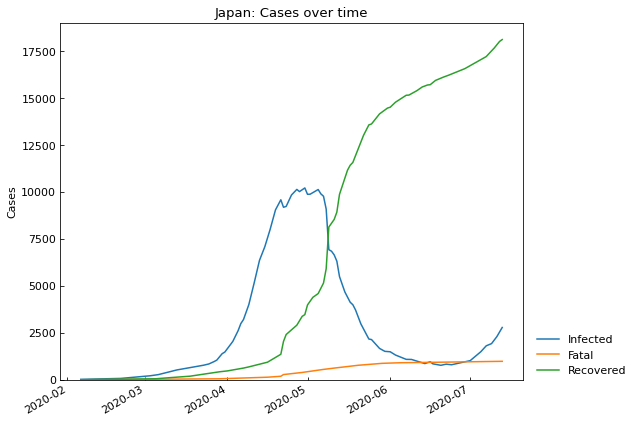

,Date,Confirmed,Infected,Fatal,Recovered
149,2020-07-09,20371,1924,981,17466
150,2020-07-10,20719,2085,982,17652
151,2020-07-11,21129,2298,982,17849
152,2020-07-12,21502,2517,982,18003
153,2020-07-13,21868,2783,982,18103


In [25]:
record_df = scenario.records()
record_df.tail()

### S-R trend analysis

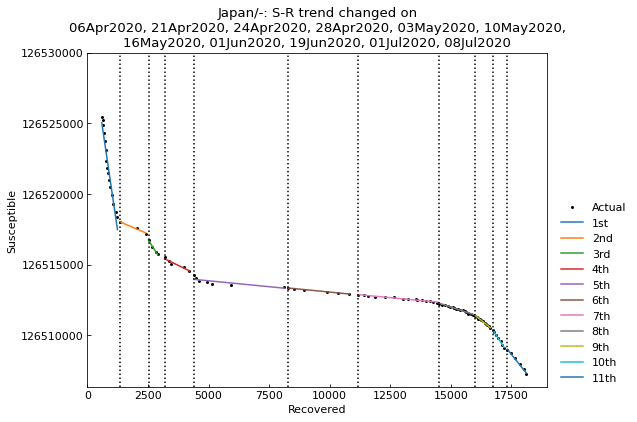

,Type,Start,End,Population
1st,Past,06Apr2020,20Apr2020,126529100
2nd,Past,21Apr2020,23Apr2020,126529100
3rd,Past,24Apr2020,27Apr2020,126529100
4th,Past,28Apr2020,02May2020,126529100
5th,Past,03May2020,09May2020,126529100
6th,Past,10May2020,15May2020,126529100
7th,Past,16May2020,31May2020,126529100
8th,Past,01Jun2020,18Jun2020,126529100
9th,Past,19Jun2020,30Jun2020,126529100
10th,Past,01Jul2020,07Jul2020,126529100


In [26]:
scenario.trend(set_phases=True)
scenario.summary()

### Hyperparameter estimation of ODE models
As an example, use SIR-F model.
We can use SIR, SIRD, (SIRFV), (SEWIRF).

In [27]:
scenario.estimate(cs.SIRF)


<Main scenario: perform parameter estimation>

Running optimization with 8 CPUs...

	11th phase with SIR-F model finished 168 trials in 0 min 15 sec.

	1st phase with SIR-F model finished 206 trials in 0 min 20 sec.

	2nd phase with SIR-F model finished 186 trials in 0 min 20 sec.

	3rd phase with SIR-F model finished 438 trials in 1 min 1 sec.

	4th phase with SIR-F model finished 405 trials in 1 min 0 sec.

	9th phase with SIR-F model finished 59 trials in 0 min 10 sec.

	10th phase with SIR-F model finished 62 trials in 0 min 10 sec.

	5th phase with SIR-F model finished 370 trials in 1 min 1 sec.

	8th phase with SIR-F model finished 146 trials in 0 min 25 sec.

	6th phase with SIR-F model finished 353 trials in 1 min 1 sec.

	7th phase with SIR-F model finished 294 trials in 0 min 51 sec.

Completed optimization. Total: 2 min 34 sec

In [28]:
scenario.summary()

,Type,Start,End,Population,ODE,rho,sigma,theta,kappa,tau,Rt,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day],RMSLE,Trials,Runtime
1st,Past,06Apr2020,20Apr2020,126529100,SIR-F,0.007996,0.000863,0.020012,0.000002,144,9.06,0.020,53868,12,115,0.173116,206,0 min 20 sec
2nd,Past,21Apr2020,23Apr2020,126529100,SIR-F,0.004408,0.005452,0.124020,0.000068,144,0.70,0.124,1478,22,18,0.035373,186,0 min 20 sec
3rd,Past,24Apr2020,27Apr2020,126529100,SIR-F,0.003546,0.001323,0.324295,0.000084,144,1.70,0.324,1186,28,75,0.183553,438,1 min 1 sec
4th,Past,28Apr2020,02May2020,126529100,SIR-F,0.002339,0.002425,0.290605,0.000070,144,0.67,0.291,1435,42,41,0.125423,405,1 min 0 sec
5th,Past,03May2020,09May2020,126529100,SIR-F,0.001415,0.003239,0.580441,0.000041,144,0.18,0.580,2468,70,30,0.209845,370,1 min 1 sec
6th,Past,10May2020,15May2020,126529100,SIR-F,0.001617,0.007997,0.678631,0.000048,144,0.06,0.679,2081,61,12,0.104838,353,1 min 1 sec
7th,Past,16May2020,31May2020,126529100,SIR-F,0.001193,0.007765,0.684552,0.000005,144,0.05,0.685,21925,83,12,0.117519,294,0 min 51 sec
8th,Past,01Jun2020,18Jun2020,126529100,SIR-F,0.004680,0.008613,0.213681,0.000067,144,0.42,0.214,1485,21,11,0.144199,146,0 min 25 sec
9th,Past,19Jun2020,30Jun2020,126529100,SIR-F,0.010460,0.007215,0.027397,0.001819,144,1.13,0.027,54,9,13,0.073366,59,0 min 10 sec
10th,Past,01Jul2020,07Jul2020,126529100,SIR-F,0.015861,0.006147,0.027397,0.001819,144,1.94,0.027,54,6,16,0.070237,62,0 min 10 sec


### Accuracy of estimation

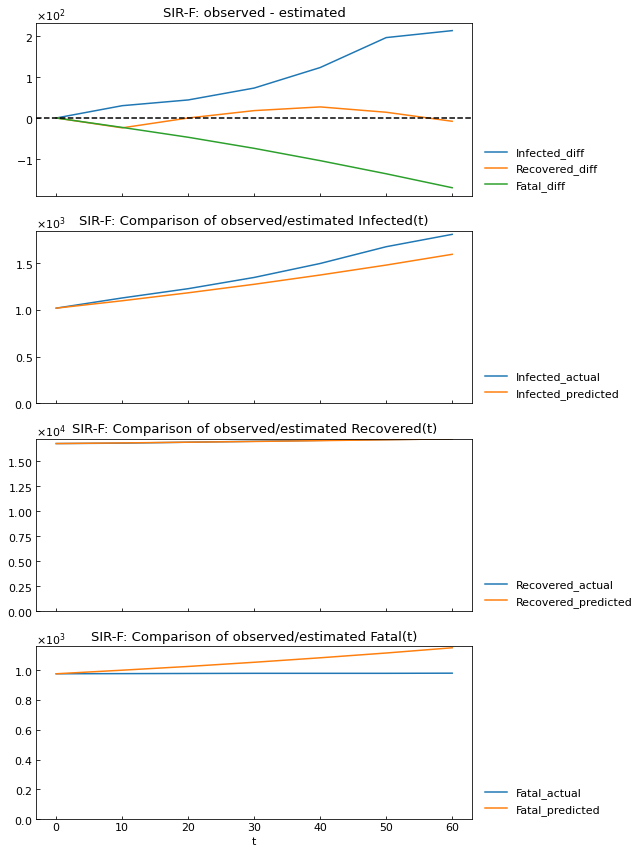

In [29]:
scenario.estimate_accuracy(phase="10th")

### Get parameter value

In [30]:
scenario.get("Rt", phase="4th")

0.67

### Show parameter history

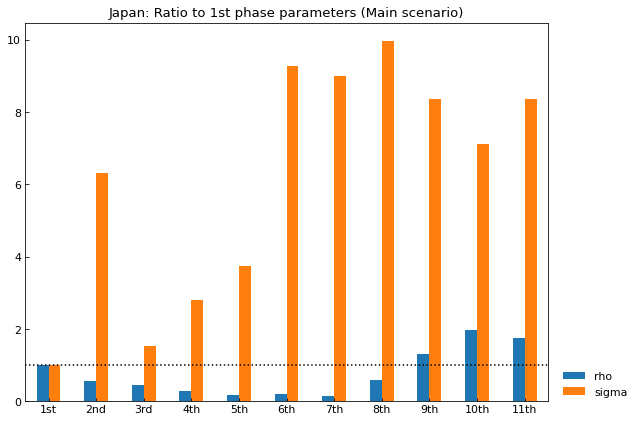

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th,11th
rho,1.0,0.551209,0.443504,0.292529,0.177007,0.202185,0.149219,0.585236,1.308105,1.983577,1.743010
sigma,1.0,6.316809,1.533150,2.809304,3.752469,9.265150,8.996770,9.979433,8.360011,7.122628,8.364895


In [31]:
df = scenario.param_history(targets=["rho", "sigma"])
df.T

### Show the history of reproduction number

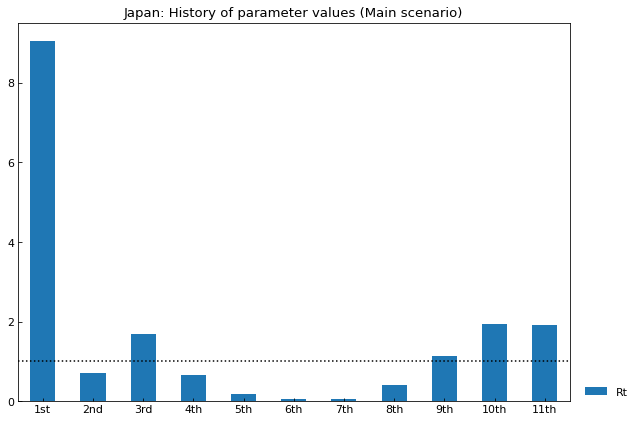

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th,11th
Rt,9.06,0.7,1.7,0.67,0.18,0.06,0.05,0.42,1.13,1.94,1.92


In [32]:
df = scenario.param_history(targets=["Rt"], divide_by_first=False, show_box_plot=True)
df.T

### Simulate the number of cases

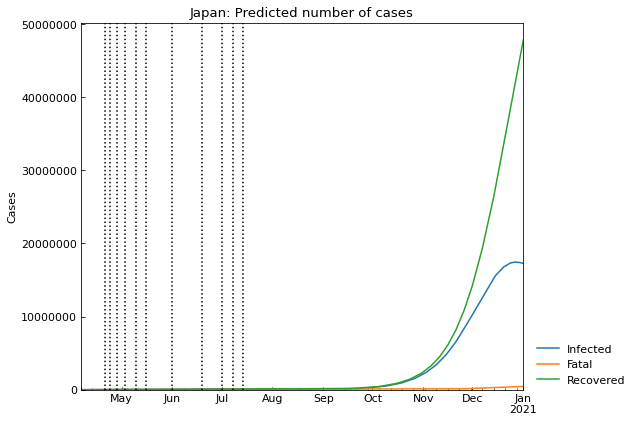

,Date,Susceptible,Infected,Recovered,Fatal
266,28Dec2020,65336561,17449587,43327761,415190
267,29Dec2020,64089495,17425995,44589735,423874
268,30Dec2020,62869099,17378863,45848747,432390
269,31Dec2020,61677108,17308657,47102609,440725
270,01Jan2021,61032960,17261325,47789579,445236


In [33]:
scenario.clear(name="Main")
scenario.add_phase(name="Main", end_date="01Jan2021")
main_sim_df = scenario.simulate(name="Main")
main_sim_df.tail()

### Simulate another scenario
If $\sigma$ will be double in 30 days, how many cases will be?

In [34]:
sigma_current = scenario.get("sigma", name="Main", phase="last")
sigma_current

0.007219690590029067

In [35]:
sigma_new = sigma_current * 2
sigma_new

0.014439381180058134

In [36]:
scenario.clear(name="Medicine")
scenario.add_phase(name="Medicine", days=30, sigma=sigma_current)
scenario.add_phase(name="Medicine", end_date="01Jan2021", sigma=sigma_new)
scenario.summary()

Type      Start        End  Population    ODE       rho  \
Scenario Phase                                                              
Main     1st      Past  06Apr2020  20Apr2020   126529100  SIR-F  0.007996   
         2nd      Past  21Apr2020  23Apr2020   126529100  SIR-F  0.004408   
         3rd      Past  24Apr2020  27Apr2020   126529100  SIR-F  0.003546   
         4th      Past  28Apr2020  02May2020   126529100  SIR-F  0.002339   
         5th      Past  03May2020  09May2020   126529100  SIR-F  0.001415   
         6th      Past  10May2020  15May2020   126529100  SIR-F  0.001617   
         7th      Past  16May2020  31May2020   126529100  SIR-F  0.001193   
         8th      Past  01Jun2020  18Jun2020   126529100  SIR-F  0.004680   
         9th      Past  19Jun2020  30Jun2020   126529100  SIR-F  0.010460   
         10th     Past  01Jul2020  07Jul2020   126529100  SIR-F  0.015861   
         11th     Past  08Jul2020  13Jul2020   126529100  SIR-F  0.013938   
         12th   Future  14Jul2020  01Jan2021   126529100  SIR-F  0.013938   
Medicine 1st      Past  06Apr2020  20Apr2020   126529100  SIR-F  0.007996   
         2nd      Past  21Apr2020  23Apr2020   126529100  SIR-F  0.004408   
         3rd      Past  24Apr2020  27Apr2020   126529100  SIR-F  0.003546   
         4th      Past  28Apr2020  02May2020   126529100  SIR-F  0.002339   
         5th      Past  03May2020  09May2020   126529100  SIR-F  0.001415   
         6th      Past  10May2020  15May2020   126529100  SIR-F  0.001617   
         7th      Past  16May2020  31May2020   126529100  SIR-F  0.001193   
         8th      Past  01Jun2020  18Jun2020   126529100  SIR-F  0.004680   
         9th      Past  19Jun2020  30Jun2020   126529100  SIR-F  0.010460   
         10th     Past  01Jul2020  07Jul2020   126529100  SIR-F  0.015861   
         11th     Past  08Jul2020  13Jul2020   126529100  SIR-F  0.013938   
         12th   Future  14Jul2020  13Aug2020   126529100  SIR-F  0.013938   
         13th   Future  14Aug2020  01Jan2021   126529100  SIR-F  0.013938   

                   sigma     theta     kappa  tau    Rt  alpha1 [-]  \
Scenario Phase                                                        
Main     1st    0.000863  0.020012  0.000002  144  9.06       0.020   
         2nd    0.005452  0.124020  0.000068  144  0.70       0.124   
         3rd    0.001323  0.324295  0.000084  144  1.70       0.324   
         4th    0.002425  0.290605  0.000070  144  0.67       0.291   
         5th    0.003239  0.580441  0.000041  144  0.18       0.580   
         6th    0.007997  0.678631  0.000048  144  0.06       0.679   
         7th    0.007765  0.684552  0.000005  144  0.05       0.685   
         8th    0.008613  0.213681  0.000067  144  0.42       0.214   
         9th    0.007215  0.027397  0.001819  144  1.13       0.027   
         10th   0.006147  0.027397  0.001819  144  1.94       0.027   
         11th   0.007220  0.006231  0.000005  144  1.92       0.006   
         12th   0.007220  0.006231  0.000005  144  1.92       0.006   
Medicine 1st    0.000863  0.020012  0.000002  144  9.06       0.020   
         2nd    0.005452  0.124020  0.000068  144  0.70       0.124   
         3rd    0.001323  0.324295  0.000084  144  1.70       0.324   
         4th    0.002425  0.290605  0.000070  144  0.67       0.291   
         5th    0.003239  0.580441  0.000041  144  0.18       0.580   
         6th    0.007997  0.678631  0.000048  144  0.06       0.679   
         7th    0.007765  0.684552  0.000005  144  0.05       0.685   
         8th    0.008613  0.213681  0.000067  144  0.42       0.214   
         9th    0.007215  0.027397  0.001819  144  1.13       0.027   
         10th   0.006147  0.027397  0.001819  144  1.94       0.027   
         11th   0.007220  0.006231  0.000005  144  1.92       0.006   
         12th   0.007220  0.006231  0.000005  144  1.92       0.006   
         13th   0.014439  0.006231  0.000005  144  0.96       0.006   

                1/al

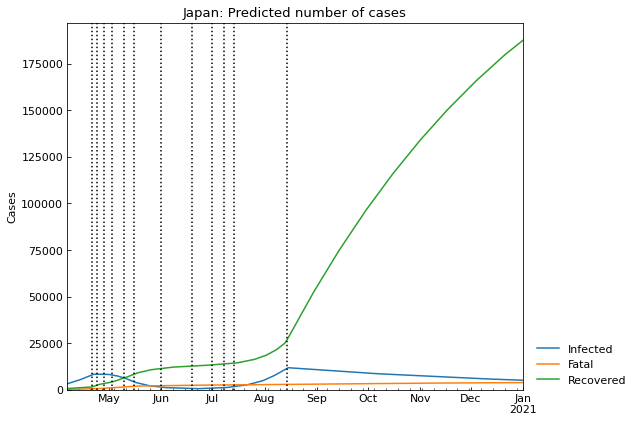

,Date,Susceptible,Infected,Recovered,Fatal
266,28Dec2020,126335019,5191,185074,3815
267,29Dec2020,126334299,5159,185822,3819
268,30Dec2020,126333583,5128,186564,3824
269,31Dec2020,126332872,5096,187302,3829
270,01Jan2021,126332483,5079,187707,3832


In [37]:
scenario.simulate(name="Medicine").tail()

### Compare the scenarios

In [38]:
scenario.describe()

,max(Infected),argmax(Infected),Infected on 01Jan2021,Fatal on 01Jan2021
Main,17449587,28Dec2020,17261325,445236
Medicine,11867,14Aug2020,5079,3832
